In [1]:
import pandas as pd
from pandas.io import sql
import MySQLdb
import numpy as np
import sklearn.ensemble
import math
import pprint
import time
import matplotlib.pyplot as plt
import sklearn as sk
from heatmap import heatmap, corrplot

import sklearn.ensemble
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_selection import mutual_info_regression, SequentialFeatureSelector


'0.24.1'

In [3]:
def df_from_query(row_start = 3499709, row_end = 4958347, training = True, srch_start = None, srch_end = None):
    """
    >>df_from_query(row_start = 7000014, row_end = 9917530, training = True, srch_start = None, srch_end = None)
      row_start,row_end: Row number range (inclusive) to request from MySQL db (faster than srch_start,srch_end)
      srch_start,srch_end: Search ID range (inclusive) to request (slower than by row_start,row_end)
      training: BOOL, to pull from Training data set to True, set to False for Test data.
    
    Query local MySQL database, (see dbcon, below for permissions) to build a pd.DataFrame for training/testing.
    
    Several columns depend on summary statistics about Properties in the PropFactors/PropFactors7M tables in the
    database.  The "7M" suffix denotes summary statistics from the first 7000013 rows which for training
    are used with the latter ~3M rows. (This is to have these latter rows more closely resemble the test set, since some 
    properties only appear a few times so the "booking_cnt" statistic is an overly strong signal if it includes 
    information from the row that is being used for training.)  However for building the Test Set predictions, it
    is better to use statistics from the entire training set.
    Since some properties will appear in the training/test sets but not among the summary sets, columns that depend
    on these statistics are set to zero.
    Can select data by row_num or srch_id (row_num is the primary key so is faster, but it may be preferrable to 
    select by srch_id where splitting searches between chunks could cause problems, like when compiling test data).
    The presence of srch_start and srch_end overrides row_start/row_end.
    
    
    """
    
    dbcon = MySQLdb.connect('localhost', 'root', 'root', 'DMT')
    #print('Run Ok')
    # MySQL server, user, password, and database

    main_cols = "SELECT row_num, srch_id, s.prop_id, price_usd, prop_location_score1, prop_location_score2, prop_log_historical_price, prop_review_score, random_bool, srch_adults_count, srch_booking_window, srch_children_count, srch_length_of_stay, srch_query_affinity_score, srch_room_count, visitor_hist_adr_usd, (prop_starrating / price_usd) AS star_by_price, (prop_review_score / price_usd) AS rev_by_price"

    agg_cols = ", prop_cnt, promotion_cnt, train_price_avg, (booking_cnt / prop_cnt) AS book_per_pcnt, (promotion_flag / promotion_cnt) AS promo_per_procnt, (train_price_avg / price_usd) AS avg_by_price, ((click_cnt - booking_cnt) / prop_cnt) AS click_nobook_per_pcnt"

    agg_missing = ", 0 AS prop_cnt, 0 AS promotion_cnt, 0 AS train_price_avg, 0 AS book_per_pcnt, 0 AS promo_per_procnt, 0 AS avg_by_price, 0 AS click_nobook_per_pcnt"

    if training:
        from_tables1 = ", booking_bool, click_bool FROM TrainSearch AS s, PropFactors3M AS p"
        from_tables2 = ", booking_bool, click_bool FROM TrainSearch AS s"
        missing_from_table = "PropFactors3M"
    else:
        from_tables1 = " FROM TestSearch AS s, PropFactors AS p"
        from_tables2 = " FROM TestSearch AS s"
        missing_from_table = "PropFactors"

    if (srch_start is not None) or (srch_end is not None):
        if (srch_start is None):
            raise Exception("Expected selection pair (srch_start, srch_end) OR (row_start, row_end). Got: srch_start = None")
        elif (srch_end is None):
            raise Exception("Expected selection pair (srch_start, srch_end) OR (row_start, row_end). Got: srch_end = None")
        else: 
            where_str = " AND srch_id >= " + str(srch_start) + " AND srch_id <= " + str(srch_end) + ";"
    else:
        where_str = " AND row_num >= " + str(row_start) + " AND row_num <= "+ str(row_end) + ";"

    train_dfmost = pd.read_sql(main_cols + agg_cols + from_tables1 + " WHERE p.prop_id = s.prop_id" + where_str, con = dbcon, index_col = 'row_num')
    # DataFrame.to_sql(name, con, schema=None, if_exists='fail', index=True, index_label=None, chunksize=None, dtype=None, method=None)
    train_dfpropmissing = pd.read_sql(main_cols + agg_missing + from_tables2 + " WHERE prop_id NOT IN (SELECT prop_id FROM " + missing_from_table + ")" + where_str, con = dbcon, index_col = 'row_num')
    
    dbcon.close()
    
    #display(train_dfmost.head(3))
    #print(train_dfmost.shape)
    #display(train_dfpropmissing.head(3))
    #print(train_dfpropmissing.shape)

    train_df = pd.concat([train_dfmost, train_dfpropmissing])
    train_df.sort_values(by='row_num',inplace = True)
    
    
    train_df.fillna(value = 0, inplace = True)

    return train_df

In [4]:
def agg_by_srch(train_df):
    """
    >>agg_by_srch(train_df)
    
    Given a training/testing dataset that includes the columns listed in cols_in below, calculate
    new columns that normalize these values among the search in which they appear by dividing by
    the mean (or median for 'price_usd' since it has higher variance).  i.e. given prop_location_score "j"
    for search "i" add column: prop_location_score[i][j] / mean(prop_location_score[i])
    """
    
    cols_in = ['prop_location_score1', 
               'prop_location_score2', 
               'book_per_pcnt', 
               'avg_by_price', 
               'rev_by_price', 
               'star_by_price', 
               'promo_per_procnt',
               'prop_log_historical_price', 
               'click_nobook_per_pcnt']

    cols_out = ['srch_ploc_score1_mean', 
                'srch_ploc_score2_mean', 
                'srch_book_per_pcnt_mean', 
                'srch_avg_by_price_mean', 
                'srch_rev_by_price_mean', 
                'srch_star_by_price_mean', 
                'srch_promo_per_procnt_mean', 
                'srch_prop_log_historical_price_mean', 
                'click_nobook_per_pcnt_mean']

    srch_df = train_df[['srch_id'] + cols_in].groupby(by='srch_id').mean()
    srch_df.columns = cols_out

    srch_df['srch_price_med'] = train_df[['srch_id','price_usd']].groupby(by = 'srch_id').median()
    srch_df['srch_id'] = srch_df.index
    
    cols_inp = list(cols_in)
    cols_outp = list(cols_out)
    cols_inp.append('price_usd')
    cols_outp.append('srch_price_med')

    cols_agg = ['ploc_score1_by_mean', 
                'ploc_score2_by_mean', 
                'book_per_pcnt_by_mean', 
                'avg_by_price_by_mean', 
                'rev_by_price_by_mean', 
                'star_by_price_by_mean', 
                'promo_perprocnt_by_mean', 
                'loghistp_by_mean', 
                'click_nobper_pcnt_by_mean',
                'price_by_med']

    for i in range(len(cols_inp)):
        train_df[cols_agg[i]] = train_df[cols_inp[i]] / train_df.join(srch_df[['srch_id', cols_outp[i]]], on='srch_id', rsuffix = '_agg')[cols_outp[i]]
    
    train_df.fillna(value = 0, inplace = True)
    train_df.loc[train_df.price_by_med == np.inf, 'price_by_med'] = 0

    return train_df

In [5]:
def ndcg_calc(train_df, pred_scores):
    """
    >>ndcg_calc(train_df, pred_scores)
       train_df: pd.DataFrame with Expedia Columns: 'srch_id', 'booking_bool', 'click_bool'
       pred_scores: np.Array like vector of scores with length = num. rows in train_df
       
    Calculate Normalized Discounted Cumulative Gain for a dataset is ranked with pred_scores (higher score = higher rank).
    If 'booking_bool' == 1 then that result gets 5 points.  If 'click_bool' == 1 then that result gets 1 point (except:
    'booking_bool' = 1 implies 'click_bool' = 1, so only award 5 points total).  
    
    NDCG = DCG / IDCG
    DCG = Sum( (2 ** points - 1) / log2(rank_in_results + 1) )
    IDCG = Maximum possible DCG given the set of bookings/clicks in the training sample.
    
    """
    eval_df = train_df[['srch_id', 'booking_bool', 'click_bool']]
    eval_df['score'] = pred_scores

    logger = lambda x: math.log(x + 1, 2)
    eval_df['log_rank'] = eval_df.groupby(by = 'srch_id')['score'].rank(ascending = False).map(logger)

    book_dcg = (eval_df['booking_bool'] * 31.0 / eval_df['log_rank']).sum() #where 2 ** 5 - 1.0 = 31.0
    book_idcg = (31.0 * eval_df['booking_bool']).sum()
    
    click_dcg = (eval_df['click_bool'] * (eval_df['booking_bool'] == 0) / eval_df['log_rank']).sum()
    
    # Max number of clicks in training set is 30.
    # Calculate the 31 different contributions to IDCG that 0 to 30 clicks have
    # and put in dict {num of click: IDCG value}.
    disc = [1.0 / math.log(i + 1, 2) if i != 0 else 0 for i in range(31)]
    disc_dict = { i: np.array(disc).cumsum()[i] for i in range(31)}
    
    # Map the number of clicks to its IDCG and subtract off any clicks due to bookings
    # since these were accounted for in book_idcg.
    click_idcg = (eval_df.groupby(by = 'srch_id')['click_bool'].sum().map(disc_dict) - eval_df.groupby(by = 'srch_id')['booking_bool'].sum()).sum()

    return (book_dcg + click_dcg) / (book_idcg + click_idcg)

In [6]:
tic= time.time()
train_df = df_from_query()
toc= time.time()

print('Time for loading in data:', toc-tic)

Time for loading in data: 153.55983638763428


In [7]:
agg_by_srch(train_df)

train_df['Relevance_target']= train_df['click_bool']*1
train_df['Relevance_target']+= train_df['booking_bool']*4

In [8]:
train_df.head()

,srch_id,prop_id,price_usd,prop_location_score1,prop_location_score2,prop_log_historical_price,prop_review_score,random_bool,srch_adults_count,srch_booking_window,...,ploc_score2_by_mean,book_per_pcnt_by_mean,avg_by_price_by_mean,rev_by_price_by_mean,star_by_price_by_mean,promo_perprocnt_by_mean,loghistp_by_mean,click_nobper_pcnt_by_mean,price_by_med,Relevance_target
row_num,,,,,,,,,,,,,,,,,,,,,
3499709,234949,1533,263.80,2.77,0.2062,5.23,4.5,0,1,119,...,3.376177,2.556783,0.540682,1.278574,1.112661,0.0,0.977844,0.500000,0.990110,0
3499710,234949,3821,340.83,3.81,0.0000,5.31,0.0,0,1,119,...,0.000000,0.000000,0.725881,0.000000,0.861192,0.0,0.992802,0.000000,1.279224,0
3499711,234949,14126,441.07,3.87,0.0090,6.05,4.0,0,1,119,...,0.147360,0.300798,1.914339,0.679736,0.831841,20.0,1.131158,0.352518,1.655451,0
3499712,234949,22673,221.59,2.30,0.0000,5.32,4.0,0,1,119,...,0.000000,0.960712,0.641283,1.353000,1.324608,0.0,0.994671,0.561151,0.831685,0
3499713,234949,27999,221.59,2.40,0.0076,5.44,4.5,0,1,119,...,0.124437,2.077962,1.749045,1.522125,1.324608,0.0,1.017108,0.539568,0.831685,0


In [9]:
train_df.describe()

,srch_id,prop_id,price_usd,prop_location_score1,prop_location_score2,prop_log_historical_price,prop_review_score,random_bool,srch_adults_count,srch_booking_window,...,ploc_score2_by_mean,book_per_pcnt_by_mean,avg_by_price_by_mean,rev_by_price_by_mean,star_by_price_by_mean,promo_perprocnt_by_mean,loghistp_by_mean,click_nobper_pcnt_by_mean,price_by_med,Relevance_target
count,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,...,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06,1.458639e+06
mean,2.838186e+05,7.007041e+04,2.067941e+02,2.871960e+00,1.020733e-01,4.316676e+00,3.771471e+00,2.955961e-01,1.978111e+00,3.737008e+01,...,9.709839e-01,9.938998e-01,9.994522e-01,9.999356e-01,9.998739e-01,8.931134e-01,8.590124e-01,9.892263e-01,1.104174e+00,1.570382e-01
std,2.818612e+04,4.059848e+04,6.090288e+03,1.530743e+00,1.512895e-01,1.836664e+00,1.060535e+00,4.563104e-01,8.639729e-01,5.134816e+01,...,1.373606e+00,1.317995e+00,5.301827e-01,4.545812e-01,3.908309e-01,2.992981e+00,3.591757e-01,1.457486e+00,6.533640e-01,8.328180e-01
min,2.349490e+05,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.593840e+05,3.499300e+04,8.500000e+01,1.790000e+00,1.300000e-03,4.450000e+00,3.500000e+00,0.000000e+00,2.000000e+00,4.000000e+00,...,3.806228e-02,0.000000e+00,8.511342e-01,7.754747e-01,7.971161e-01,0.000000e+00,9.263233e-01,0.000000e+00,7.987013e-01,0.000000e+00
50%,2.838170e+05,6.961500e+04,1.220000e+02,2.770000e+00,3.540000e-02,4.910000e+00,4.000000e+00,0.000000e+00,2.000000e+00,1.700000e+01,...,6.362750e-01,6.744634e-01,9.742632e-01,9.860590e-01,9.850821e-01,0.000000e+00,9.886507e-01,6.396600e-01,1.000000e+00,0.000000e+00
75%,3.082090e+05,1.051480e+05,1.840000e+02,4.040000e+00,1.383000e-01,5.310000e+00,4.500000e+00,1.000000e+00,2.000000e+00,4.900000e+01,...,1.394658e+00,1.423218e+00,1.100366e+00,1.211166e+00,1.193572e+00,0.000000e+00,1.036603e+00,1.436162e+00,1.247144e+00,0.000000e+00
max,3.327850e+05,1.408210e+05,4.216286e+06,6.980000e+00,1.000000e+00,6.210000e+00,5.000000e+00,1.000000e+00,9.000000e+00,4.820000e+02,...,3.500000e+01,3.300000e+01,3.210337e+01,2.210703e+01,2.900000e+01,3.600000e+01,5.000000e+00,3.400000e+01,2.010937e+02,5.000000e+00


In [10]:
df= train_df.copy()[:int(2e4)]
df.shape

(20000, 37)

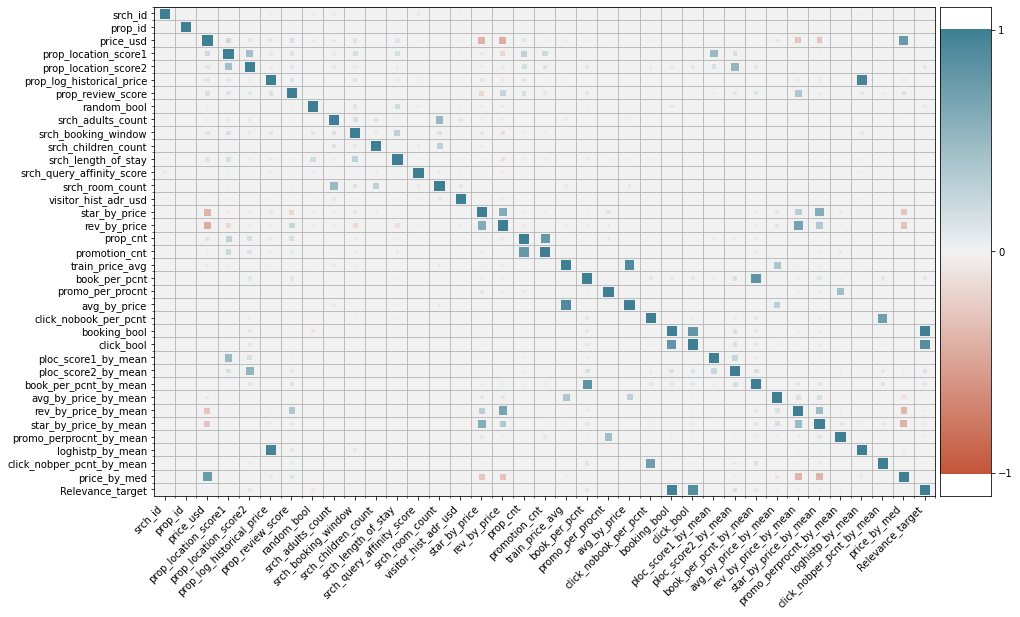

In [11]:
plt.figure(figsize=(15,9))
corrplot(df.corr(),size_scale=85)

In [12]:
Target_features= ['click_bool', 'booking_bool', 'Relevance_target']
Selected_features= df.columns.drop(Target_features)

# Removing outliers
df = df.loc[(df['price_usd'] <= 2000.0) * (df['price_usd'] != 0.0)]

# Separate target from predictors
y = df[['srch_id']+Target_features]
X = df[Selected_features]

# Divide data into training and validation subsets
train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(df, groups=df['srch_id']))
X_train = X.iloc[train_inds]
X_valid = X.iloc[test_inds]
y_train = y.iloc[train_inds]
y_valid = y.iloc[test_inds]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

C:\Users\stijn\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


In [13]:
# Preprocessing for numerical data
numerical_transformer = MinMaxScaler()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, Selected_features),
    ])

model = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, min_samples_split = 1000, random_state=0)
# model = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                         ('model', model)
                        ])

In [14]:
# Preprocessing of training data, fit model 
tic= time.time()
pipeline.fit(X_train, y_train['Relevance_target'])
toc= time.time()
print('Training time is', toc-tic)

model= pipeline['model']

Training time is 22.801496267318726


In [15]:
# Get predictions
if hasattr(model, 'predict_proba'):
    preds = model.predict_proba(X_valid)[:, 1]
else:
    preds = model.predict(X_valid)

ndcg= ndcg_calc(y_valid, preds)

print('NDCG is', ndcg)

NDCG is 0.31154563277998376


### Sequential Feature Selection(SFS)

SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. This can done either in a forward and backward manner. In a forward SFS we start with zero feature and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the $\text{n_features_to_select}$ parameter.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no feature and greedily adding features, we start with all the features and greedily remove features from the set. 

Paper about this- http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.24.4369&rep=rep1&type=pdf

In [ ]:
Estimator = sklearn.ensemble.RandomForestRegressor(n_estimators = 100, min_samples_split = 1000, random_state=0)
# Estimator = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000, random_state=0)
# Estimator = svm.SVR()

tic_fwd = time.time()
sfs_forward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, direction='forward').fit(X_train, y_train['Relevance_target'])
toc_fwd = time.time()

tic_bwd = time.time()
sfs_backward = SequentialFeatureSelector(Estimator, n_features_to_select=12, n_jobs=-1, direction='backward').fit(X_train, y_train['Relevance_target'])
toc_bwd = time.time()

print("Features selected by forward sequential selection: "f"{X_train.columns[sfs_forward.get_support()].tolist()}")
print(f"Done in {toc_fwd - tic_fwd:.3f}s")
print("Features selected by backward sequential selection: "f"{X_train.columns[sfs_backward.get_support()].tolist()}")
print(f"Done in {toc_bwd - tic_bwd:.3f}s")

### Tree Based Feature Selection

Tree-based models assign weights to the features using feature importances based on the mean decrease in impurity (MDI). Impurity is quantified by the splitting criterion of the decision trees (Gini, Entropy or Mean Squared Error). However, this method can give high importance to features that may not be predictive on unseen data when the model is overfitting. Permutation-based feature importance, on the other hand, avoids this issue, since it can be computed on unseen data. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature.

Furthermore, impurity-based feature importance for trees are strongly biased and favor high cardinality features (typically numerical features) over low cardinality features such as binary features or categorical variables with a small number of possible categories.

Permutation-based feature importances do not exhibit such a bias. Additionally, the permutation feature importance may be computed performance metric on the model predictions predictions and can be used to analyze any model class (not just tree-based models).

More about this:  https://scikit-learn.org/stable/modules/permutation_importance.html#id2

Paper:  L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001. https://doi.org/10.1023/A:1010933404324

In [ ]:
tree_feature_importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]

feature_names = X_train.columns.values #np.r_[feature_names, numerical_columns]

#tree_feature_importances = ( rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort().tolist()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots(figsize=[12,8])
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()
#fig.savefig('rfr_importance.png', dpi = 200)

### Univariate Feature selection using Mutual Information 
Mutual information between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. 

More about this on : https://en.wikipedia.org/wiki/Mutual_information

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html#r37d39d7589e2-1

In [ ]:
mi = mutual_info_regression(X_train[['prop_location_score2', 'price_usd']], y_train['Relevance_target'], discrete_features=False)
mi /= np.max(mi)

plt.figure(figsize=(15, 12))
for i in range(X_train[['prop_location_score2', 'price_usd']].shape[1]):
    plt.subplot(np.ceil(X_train[['prop_location_score2', 'price_usd']].shape[1]/4), 4, i + 1)
    plt.scatter(X_train.iloc[:, i], y_train['Relevance_target'], edgecolor='black', s=20)
    plt.xlabel("{}".format(X_train[['prop_location_score2', 'price_usd']].iloc[:, i].name), fontsize=14)
    if i%3== 0:
        plt.ylabel("target", fontsize=14)
    plt.title("MI={:.2f}".format(mi[i]), fontsize=16)
plt.tight_layout()
plt.show()
#plt.savefig('mutual_info.png', dpi = 600)

In [ ]:
def trainer(X_train, y_train, pipeline, Selected_features, target= 'click_bool'):
    
    pipeline.fit(X_train[Selected_features], y_train[target])
    
    return pipeline